# Computer Vision and Advanced Machine Learning area of the project.
### Author: Hugo Iglesias Pombo (2025)
### NO2: EDA and preprocessing of the datasets and Attention U-Net architecture

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

# Ajuste para usar MPS en MacBook Pro M4 Pro
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando MPS (GPU de Apple)")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Usando CUDA")
else:
    device = torch.device("cpu")
    print("Usando CPU")

# Carga de imágenes - ajusta la ruta según donde estén tus datos
masks = glob.glob("/Volumes/Proyecto_Hugo/breast-cancer-analysis/datasets/Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
series = list(zip(images, masks))


Usando MPS (GPU de Apple)


In [2]:
# Función de visualización del dataset original
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])
    
    f, axarr = plt.subplots(1, 3, figsize=(5, 5))
    
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel('Axial View', fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [3]:
# Dataset y particiones
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])
train, test = train_test_split(dataset, test_size=0.25)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (585, 2)
Test shape: (195, 2)


In [4]:
# Dataset personalizado (igual que el original)
class CustomImageMaskDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L') 
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask


In [5]:
# Transformaciones
image_size = 128  # Mantenemos el tamaño original de 128
    
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


In [6]:
# Crear datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

In [7]:
# DataLoaders
batch_size = 16  # Mantenemos el batch size original
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
# Bloque convolucional (igual que el original)
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()
        
        self.dropout = nn.Dropout(dropout)
        
        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)
        
        x = self.dropout(x)
        
        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x


In [9]:
# Encoder (igual que el original)
class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p


In [10]:
# Mecanismo de atención simple
class SimpleAttention(nn.Module):
    def __init__(self, in_channels):
        super(SimpleAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Generar mapa de atención
        attn = self.conv(x)
        attn = self.sigmoid(attn)
        
        # Aplicar atención a la entrada
        return x * attn


In [11]:
# Decoder (igual que el original pero con atención)
class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        
        # Agregar mecanismo de atención simple
        self.attention = SimpleAttention(output_channel)
        
        self.conv2d_1 = ConvBlock(output_channel*2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, skip):
        x = self.conv_t(x)
        
        # Aplicar mecanismo de atención al skip connection
        skip_with_attention = self.attention(skip)
        
        x = torch.cat([x, skip_with_attention], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

In [12]:
# U-Net con Atención (modificación mínima)
class AttentionUnet(nn.Module):
    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.07)
        self.encoder_2 = Encoder(64, 128, 0.08)
        self.encoder_3 = Encoder(128, 256, 0.09)
        self.encoder_4 = Encoder(256, 512, 0.1)

        self.conv_block = ConvBlock(512, 1024, 0.11)

        # Usamos los decoders con atención
        self.decoder_1 = Decoder(1024, 512, 0.1)
        self.decoder_2 = Decoder(512, 256, 0.09)
        self.decoder_3 = Decoder(256, 128, 0.08)
        self.decoder_4 = Decoder(128, 64, 0.07)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid() 

    def forward(self, x):
        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)

        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)

        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)
        
        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final


In [13]:
# Clase Trainer (igual que el original)
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15

        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice
    
    def iou(self, pred_mask, true_mask):
        intersection = torch.logical_and(pred_mask, true_mask).sum().item()
        union = torch.logical_or(pred_mask, true_mask).sum().item()
        iou_score = intersection / union if union != 0 else 0.0
        return iou_score

    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            self.save_best_model(epoch + 1, avg_val_dice)
            
    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }


In [14]:
# Funciones de pérdida (igual que el original)
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score


In [15]:
# Inicialización del modelo
attention_unet = AttentionUnet(1).to(device)

learning_rate = 0.0001
weight_decay = 1e-6

optimizer = optim.Adam(attention_unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Trainer(model=attention_unet, num_epochs=50, optimizer=optimizer, criterion=bce_dice_loss, device=device)


In [16]:
# Función para entrenar el modelo
def train_model():
    print("Iniciando entrenamiento...")
    trainer.train(train_dataloader, test_dataloader)
    metrics = trainer.get_metrics()
    return metrics


In [17]:
# Función para visualizar predicciones
def to_numpy(tensor):
    # Manejo para MPS (Apple Silicon)
    if tensor.device.type == 'mps':
        return tensor.detach().cpu().numpy()
    return tensor.cpu().detach().numpy()


In [18]:
def threshold_prediction(predicted, threshold=0.5):
    predicted_np = to_numpy(predicted)
    predicted_np[predicted_np < threshold] = 0
    predicted_np[predicted_np >= threshold] = 1
    return predicted_np


In [ ]:
def plot_prediction(model, dataset, idx=None, threshold=0.3):
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    
    model.eval()
    
    # Obtener imagen y máscara del dataset
    image, mask = dataset[idx]
    
    # Preparar imagen para la inferencia
    image_tensor = image.unsqueeze(0).to(device)
    
    # Preparar máscara para comparación (asegurando que esté en el mismo dispositivo)
    mask = mask.to(device)
    
    # Generar predicción
    with torch.no_grad():
        pred = model(image_tensor)
        pred = pred.squeeze()  # Eliminar dimensión de batch
    
    # Calcular Dice score correctamente en el dispositivo
    # Primero binarizar la predicción usando el umbral
    pred_binary_tensor = (pred > threshold).float()
    
    # Asegurar que la máscara y la predicción tienen la misma forma
    if pred_binary_tensor.shape != mask.shape:
        mask = mask.squeeze()  # Si hay dimensiones extra en la máscara
    
    # Calcular Dice score
    dice_score = trainer.dice_coeff(pred_binary_tensor, mask)
    
    # Convertir a NumPy para visualización
    image_np = to_numpy(image.squeeze())
    mask_np = to_numpy(mask.cpu() if mask.device.type != 'cpu' else mask)
    pred_np = to_numpy(pred)
    pred_binary_np = to_numpy(pred_binary_tensor)
    
    # Visualizar
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    
    axes[0].imshow(image_np, cmap='gray')
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')
    
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Máscara Real')
    axes[1].axis('off')
    
    axes[2].imshow(pred_np, cmap='jet')
    axes[2].set_title('Predicción (Probabilidades)')
    axes[2].axis('off')
    
    axes[3].imshow(pred_binary_np, cmap='gray')
    axes[3].set_title(f'Predicción (Umbral={threshold})')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f'Dice Score: {dice_score.item():.4f}')

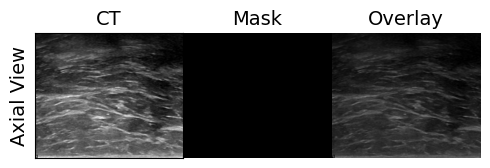

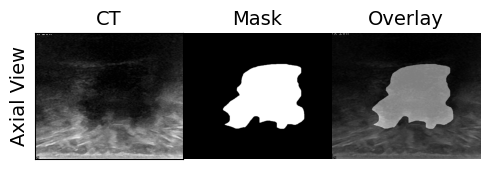

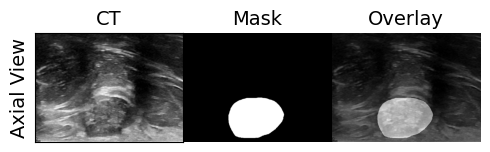

Iniciando entrenamiento...
Epoch [1/50], Step [15/37], Loss: 0.8585, Dice Coef: 0.3859
Epoch [1/50], Step [30/37], Loss: 0.6865, Dice Coef: 0.5370
Epoch [1/50], Train Loss: 0.8180, Val Loss: 0.9149
Epoch [1/50], Train Dice: 0.3997, Val Dice: 0.3965
Epoch [2/50], Step [15/37], Loss: 0.8183, Dice Coef: 0.4257
Epoch [2/50], Step [30/37], Loss: 0.8742, Dice Coef: 0.3289
Epoch [2/50], Train Loss: 0.7812, Val Loss: 0.8997
Epoch [2/50], Train Dice: 0.4210, Val Dice: 0.4142
Epoch [3/50], Step [15/37], Loss: 0.7970, Dice Coef: 0.4163
Epoch [3/50], Step [30/37], Loss: 0.7585, Dice Coef: 0.4494
Epoch [3/50], Train Loss: 0.7521, Val Loss: 0.9225
Epoch [3/50], Train Dice: 0.4402, Val Dice: 0.3746
Epoch [4/50], Step [15/37], Loss: 0.6232, Dice Coef: 0.5519
Epoch [4/50], Step [30/37], Loss: 0.7276, Dice Coef: 0.4580
Epoch [4/50], Train Loss: 0.7486, Val Loss: 0.7762
Epoch [4/50], Train Dice: 0.4401, Val Dice: 0.4302
Epoch [5/50], Step [15/37], Loss: 0.9758, Dice Coef: 0.2977
Epoch [5/50], Step [30/37

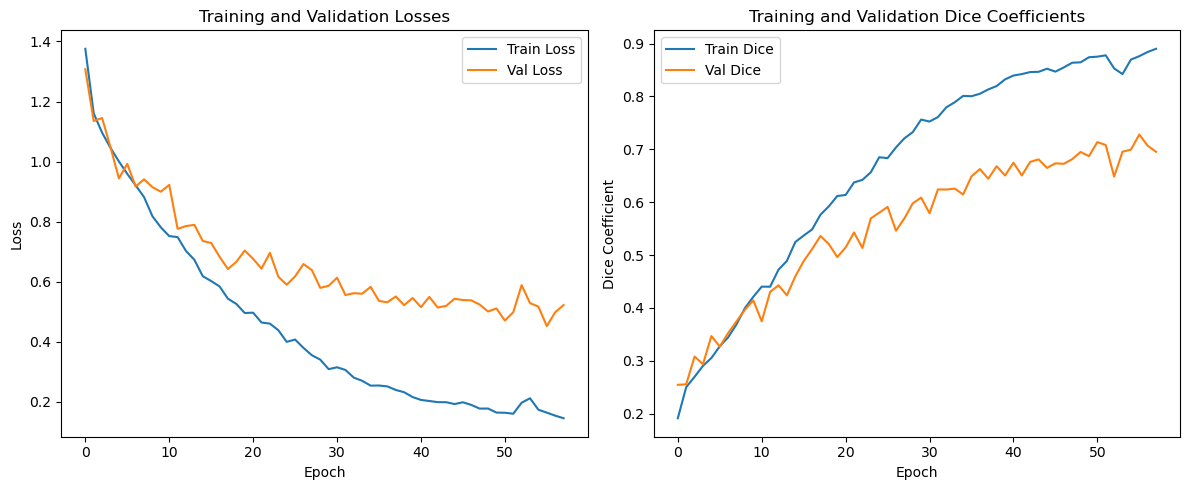

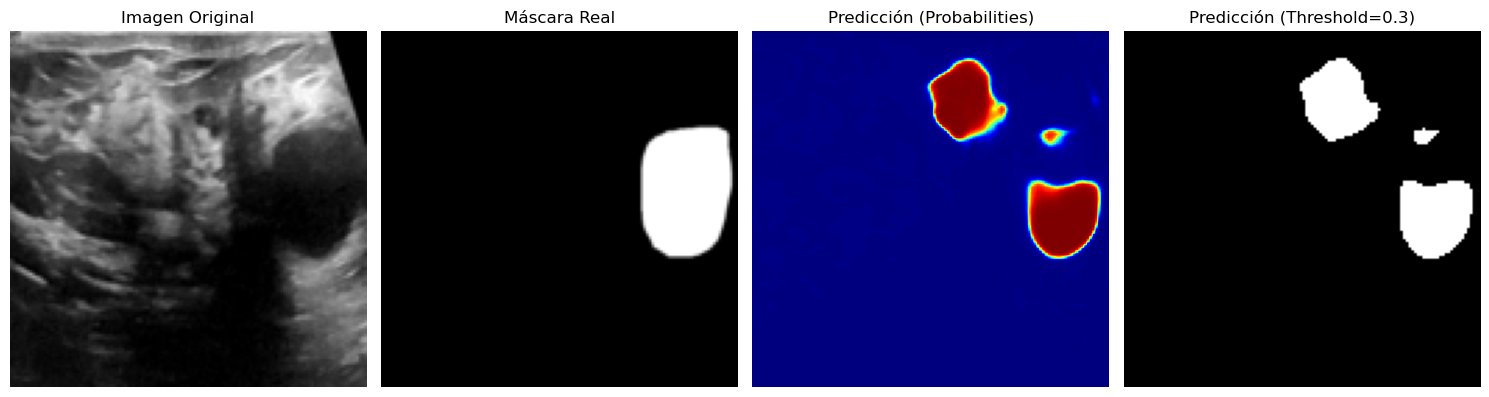

Dice Score: 0.4956


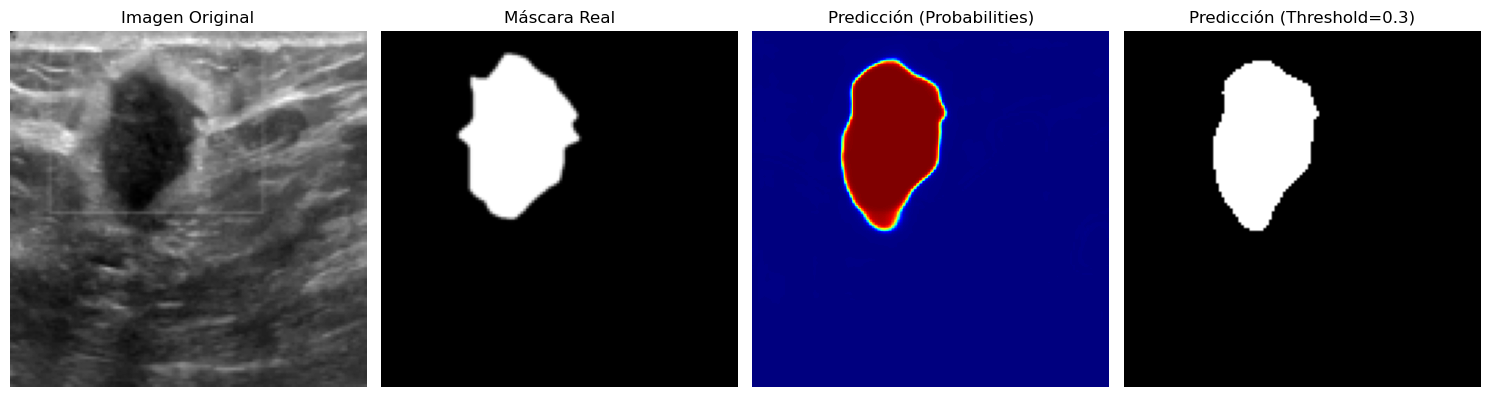

Dice Score: 0.9250


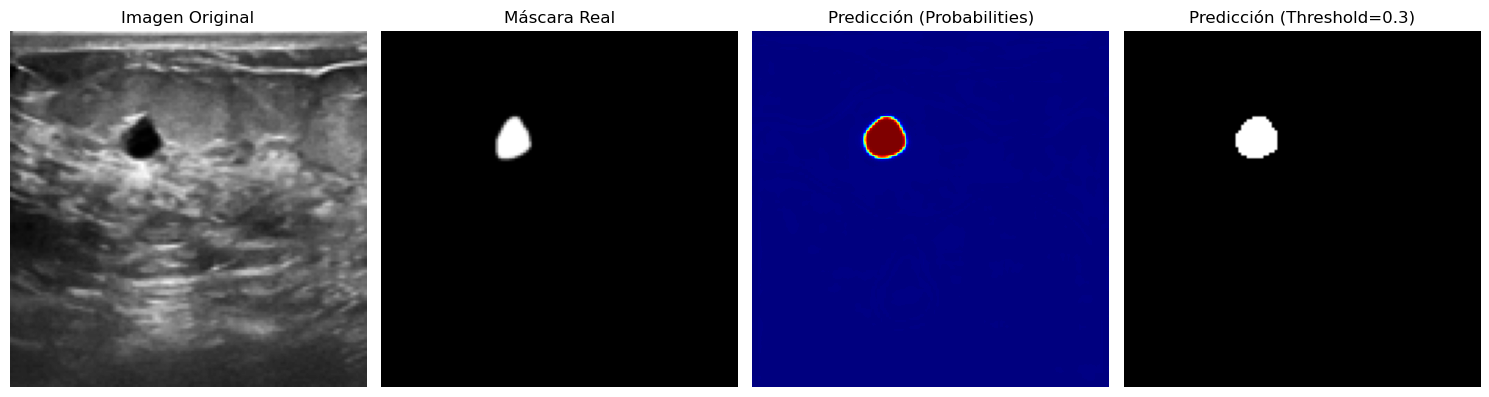

Dice Score: 0.8452
Entrenamiento completado. Mejor Dice: 0.7280018925666809


In [21]:
# Función principal
def main():
    # Mostrar algunas imágenes del dataset
    random_image_indices = random.sample(range(min(len(series), 750)), 3)
    for idx in random_image_indices:
        plot_train_label(series[idx])
    
    # Entrenar modelo
    metrics = train_model()
    
    # Visualizar métricas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    train_dices = [t.item() if torch.is_tensor(t) else t for t in metrics['train_dices']]
    val_dices = [t.item() if torch.is_tensor(t) else t for t in metrics['val_dices']]
    plt.plot(train_dices, label='Train Dice')
    plt.plot(val_dices, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Visualizar algunas predicciones
    for i in [20, 55, 87]:
        plot_prediction(attention_unet, test_dataset, i, threshold=0.3)
    
    # Guardar el modelo final
    torch.save({
        'model_state_dict': attention_unet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
    }, 'breast_segmentation_model.pth')
    
    print(f"Entrenamiento completado. Mejor Dice: {metrics['best_dice']}")
    return attention_unet, metrics

# Para ejecutar todo el proceso:
model, metrics = main()